# Predicting Airbnb Price of listing per Night

Since its inception in 2008, Airbnb has disrupted the traditional hospitality industry as more travellers decide to use Airbnb as their primary means of accommodation. Airbnb offers travellers a more unique and personalized way of accommodation and experience

This dataset has columns describing:

- host id: unique host id
- host name: name of host
- listing id: unique listing id
- listing name: name of listing
- latitude
- longitude
- the neighbourhood: name of neighbourhood
- room type
- minimum number of nights
- number of reviews
- last review date
- reviews per month 
- availability_365: number of days in year the listing is available for rent
- host listings
- city
- price: price of listing per night

Acknowledgements

This dataset is a compilation of multiple datasets found on Inside Airbnb.

In [1]:
# regular expressions
import re 

# math and data utilities
import numpy as np
import pandas as pd
import scipy.stats as ss
import itertools as it

# ML and statistics libraries
import xgboost as xgb
import scipy.stats as stats
from scipy.special import boxcox1p
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVC
import lightgbm as lgb

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [114]:
df = pd.read_csv('/Users/rosagradilla/Documents/Projects/data/AB_US_2020.csv')

/Users/rosagradilla/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [115]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [4]:
display(df.shape)
display(df.info())

(226030, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226030 entries, 0 to 226029
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              226030 non-null  int64  
 1   name                            226002 non-null  object 
 2   host_id                         226030 non-null  int64  
 3   host_name                       225997 non-null  object 
 4   neighbourhood_group             110185 non-null  object 
 5   neighbourhood                   226030 non-null  object 
 6   latitude                        226030 non-null  float64
 7   longitude                       226030 non-null  float64
 8   room_type                       226030 non-null  object 
 9   price                           226030 non-null  int64  
 10  minimum_nights                  226030 non-null  int64  
 11  number_of_reviews               226030 non-null  int64  
 12  last_review     

None

This dataset consists of 226,030 observations with 16 features plus our target variable, which we are predicting: <b>price of listing per night</b>

In [116]:
df.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
id,226030.0,2.547176e+07,1.317814e+07,109.00000,1.515890e+07,2.590916e+07,3.772624e+07,4.556085e+07
host_id,226030.0,9.352385e+07,9.827422e+07,23.00000,1.399275e+07,5.138266e+07,1.497179e+08,3.679176e+08
latitude,226030.0,3.566283e+01,6.849855e+00,18.92099,3.276178e+01,3.726112e+01,4.072404e+01,4.773462e+01
longitude,226030.0,-1.032207e+02,2.622209e+01,-159.71490,-1.185981e+02,-9.781720e+01,-7.691932e+01,-7.099595e+01
price,226030.0,2.197165e+02,5.703536e+02,0.00000,7.500000e+01,1.210000e+02,2.010000e+02,2.499900e+04
minimum_nights,226030.0,4.525490e+02,2.103376e+05,1.00000,1.000000e+00,2.000000e+00,7.000000e+00,1.000000e+08
number_of_reviews,226030.0,3.450653e+01,6.360291e+01,0.00000,1.000000e+00,8.000000e+00,3.900000e+01,9.660000e+02
reviews_per_month,177428.0,1.431450e+00,1.683210e+00,0.01000,2.300000e-01,8.100000e-01,2.060000e+00,4.406000e+01
calculated_host_listings_count,226030.0,1.669856e+01,5.106897e+01,1.00000,1.000000e+00,2.000000e+00,6.000000e+00,5.930000e+02
availability_365,226030.0,1.593149e+02,1.401796e+02,0.00000,0.000000e+00,1.400000e+02,3.110000e+02,3.650000e+02


## Exploratory Data Analysis (EDA)

First, I will focus on exploring missing values. I also will look at which features have the greatest impact on price. I also want to evaluate the relationship between variables. After this analysis is complete I will move on to predictive analysis.

Predicting price is a regression problem, therefore I be focusing on the following:

- <b>Variable Distributions: </b> We want to make sure our continuos variables are bell shaped for the purposes of having appropiate data to feed to our regression model.

- <b> Finding and Dealing with Missing Data: </b> We need to analyze the missing values in each one of our features and deal with them appropiately.

- <b>Linearity of Continuos Variables: </b> If our features have have linear relationships with price, we do not need to transform our data. However, if there isn't a linear relationship, then we must either transform the data or consider non-linear regression models.

- <b>Strength of Association: </b> We need to evaluate how strong is the relationship between a variable and our target, price. This would help us determine wether or not we should keep a variable.

- <b>ANOVA F-test of categorical variables against sale price: </b> Through ANOVA, we will  look at an outcome after using each one of the categories in a categorical variable. This will help us determine if a categorical variable is significant or not.

## Distribution of Target Variable: Price

First, I will plot the target variable along with a couple of transformations if necessary. We'll do this because:

1. We want to understand the distribution of our data and we can roughly determine that visually.

2. Transforming the distributions of the variables is common practice in case the data is not bell shaped.

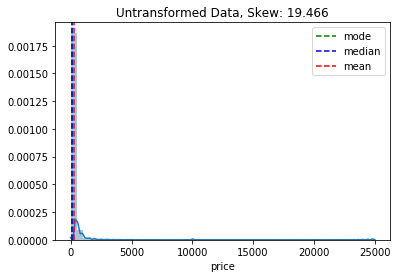

In [117]:
sigma = df.price.std()
mu = df.price.mean()
med = df.price.median()
mode = df.price.mode().to_numpy()

plt.title(f'Untransformed Data, Skew: {stats.skew(df.price):.3f}')
sns.distplot(df.price)
plt.axvline(mode, linestyle='--', color='green', label='mode')
plt.axvline(med, linestyle='--', color='blue', label='median')
plt.axvline(mu, linestyle='--', color='red', label='mean')
plt.legend()

It is very clear our response variable is right skewed, so we must transform it, We'll try log and Yeo-Johnson transformations and see which one looks better. We'll keep this in mind for when it is time to make predictions

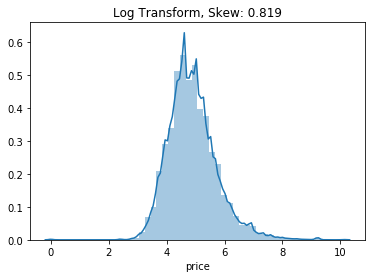

In [7]:
# Log Transform
log_data = np.log1p(df.price)
plt.title(f'Log Transform, Skew: {stats.skew(log_data):.3f}')
sns.distplot(np.log1p(df.price), kde=True)

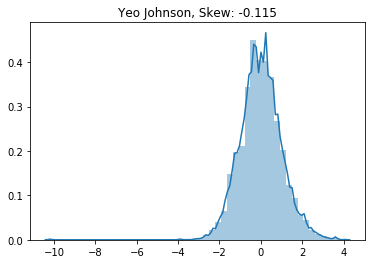

In [8]:
#Yeo-Johnson
pt = pre.PowerTransformer()
ptd = pt.fit_transform(df.price.to_numpy().reshape(-1,1))
plt.title(f'Yeo Johnson, Skew: {stats.skew(ptd.squeeze()):.3f}')
sns.distplot(ptd, kde=True)

These transformations alter the meaning of the data (notice the lack of the ‘Price’ label on the horizontal axis). The main purpose of transforming the target variable is in hopes of assisting the training of a machine learning algorithm.

The Yeo-Johnson transformation looks better than the log, we'll use that one later on.

## Removing Nulls and unnecesary columns


In [118]:
df['neighbourhood_group'].fillna('Others',inplace=True)
df.drop(['name','host_name'],axis=1,inplace=True)
df['last_review'] = pd.to_datetime(df['last_review'],infer_datetime_format=True)
df['reviews_per_month'].fillna(df['reviews_per_month'].mean(),inplace=True)
df["last_review"] = df["last_review"].replace(np.nan, df["last_review"].mode().iloc[0])
df.drop(['id','host_id'],axis=1,inplace=True)

In [119]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
city                              0
dtype: int64

Let's see how many cities we have:

In [13]:
cities = df.city.unique()
display(f'There are {len(cities)} in the dataset')

display(cities)

'There are 28 in the dataset'

array(['Asheville', 'Austin', 'Boston', 'Broward County', 'Cambridge',
       'Chicago', 'Clark County', 'Columbus', 'Denver', 'Hawaii',
       'Jersey City', 'Los Angeles', 'Nashville', 'New Orleans',
       'New York City', 'Oakland', 'Pacific Grove', 'Portland',
       'Rhode Island', 'Salem', 'San Clara Country', 'San Diego',
       'San Francisco', 'San Mateo County', 'Santa Cruz County',
       'Seattle', 'Twin Cities MSA', 'Washington D.C.'], dtype=object)

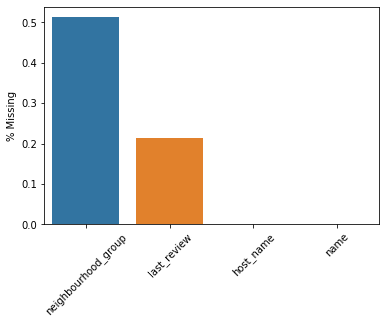

In [18]:
viz_missing(df)

# Label encoding categorical columns

In [121]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['neighbourhood_group'] = label_encoder.fit_transform(df['neighbourhood_group'])
df['neighbourhood'] = label_encoder.fit_transform(df['neighbourhood'])
df['room_type'] = label_encoder.fit_transform(df['room_type'])
df['city'] = label_encoder.fit_transform(df['city'])

In [122]:
df.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city'],
      dtype='object')

## Change date values to ordinal

In [123]:
import datetime 
df['last_review'] = df['last_review'].map(datetime.datetime.toordinal)

## Remove outliers

In [124]:
from scipy import stats
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df[filtered_entries]

## Scaling Data

In [125]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#scaler.fit(new_df)
scaled_features = scaler.fit_transform(new_df)
scaled_features_df = pd.DataFrame(scaled_features, index=new_df.index, columns=new_df.columns)

In [126]:
scaled_features_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,0.621334,-1.767512,-0.004938,0.775638,1.381058,-0.599407,-0.362783,2.555047,0.143892,-0.148009,-0.395247,-1.143297,-1.88295
1,0.621334,-1.772330,-0.012851,0.778424,-0.686353,1.386301,-0.362783,1.996818,0.701810,-0.245114,0.022237,0.921239,-1.88295
2,0.621334,-1.772330,-0.011537,0.778415,-0.686353,-0.526759,0.812551,1.415331,-0.158313,-0.439324,-0.353498,0.992924,-1.88295
5,0.621334,-1.767512,-0.009789,0.778525,-0.686353,-0.241010,-0.119610,0.601248,0.016036,-0.721810,-0.395247,0.964250,-1.88295
6,0.621334,-1.762694,-0.014965,0.776821,1.381058,-0.657525,-0.362783,2.531787,-0.158313,0.037373,-0.395247,-1.143297,-1.88295


## Getting Ready to Train a Model

In [127]:
from sklearn.model_selection import train_test_split
X = scaled_features_df.drop('price',axis=1)
y = scaled_features_df['price']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2, random_state=42)

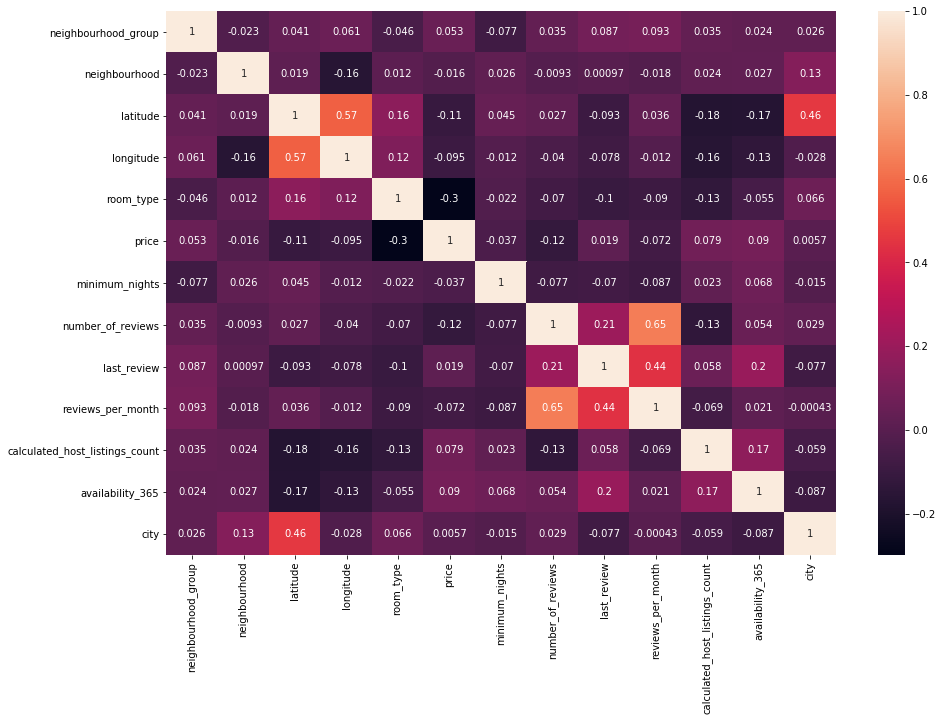

In [128]:
plt.figure(figsize=(15,10))
sns.heatmap(scaled_features_df.corr(),annot=True)

## Check multicollinearity

In [129]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                          for i in range(len(X_train.columns))] 
  
print(vif_data)

                           feature       VIF
0              neighbourhood_group  1.027844
1                    neighbourhood  1.054252
2                         latitude  2.312432
3                        longitude  1.843222
4                        room_type  1.056579
5                   minimum_nights  1.034192
6                number_of_reviews  1.792139
7                      last_review  1.342547
8                reviews_per_month  2.114312
9   calculated_host_listings_count  1.098035
10                availability_365  1.108484
11                            city  1.530459


# Linear Regression

In [130]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [131]:
y_pred = regressor.predict(X_test)

In [132]:
from sklearn.metrics import mean_squared_error,r2_score
import math
print('MSE',mean_squared_error(y_test, y_pred))
print('RMSE',math.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score',r2_score(y_test, y_pred))
print('Adj R^2 value:',1 - (1-regressor.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

MSE 0.8719020312856749
RMSE 0.9337569444377241
R2 Score 0.12616838160768917
Adj R^2 value: 0.12591044297042475


# XGBoost

In [133]:
base_booster = xgb.XGBRegressor()

# We want to shuffle the data for the cross_val_score 
kf = model_selection.KFold(5, shuffle=True, random_state=1)

In [137]:
base_booster.fit(X_train, y_train)

y_pred_xg = base_booster.predict(X_test)

In [139]:
print('MSE',mean_squared_error(y_test, y_pred_xg))
print('RMSE',math.sqrt(mean_squared_error(y_test, y_pred_xg)))
print('R2 Score',r2_score(y_test, y_pred_xg))
print('Adj R^2 value:',1 - (1-base_booster.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

MSE 0.6066817843460006
RMSE 0.7788978009636441
R2 Score 0.3919755816115271
Adj R^2 value: 0.39179610425387423
